In [1]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import glob
from tqdm import tqdm
from skimage.color import label2rgb
import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt
from matplotlib.lines import Line2D
import geopandas as gpd
from orinoco import get_cropped_profile, get_extent, make_map, get_features_from_array

import matplotlib
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
tile_name = 'NR08'

In [3]:
out = Path('out')

tile_dir = Path(f'out/{tile_name}')
tile_dir.exists()

True

In [4]:
out = Path('out')
grwl_data = Path('grwl_data')

tile_dir = out/tile_name
tile_dir_4326 = out/f'{tile_name}_4326'

In [5]:
list(tile_dir_4326.glob('*'))

[PosixPath('out/NR08_4326/segments_NR08.tif'),
 PosixPath('out/NR08_4326/distance_NR08.tif'),
 PosixPath('out/NR08_4326/ocean_mask_NR08.tif'),
 PosixPath('out/NR08_4326/width_differences.tif.aux.xml'),
 PosixPath('out/NR08_4326/segments_rgb_NR08.tif'),
 PosixPath('out/NR08_4326/water_mask_dilated_NR08.tif'),
 PosixPath('out/NR08_4326/width_differences.tif'),
 PosixPath('out/NR08_4326/water_mask_NR08.tif')]

In [6]:
with rasterio.open(tile_dir_4326/f'segments_{tile_name}.tif') as ds:
    segments = ds.read(1)
with rasterio.open(tile_dir_4326/f'ocean_mask_{tile_name}.tif') as ds:
    ocean_mask = ds.read(1)
    
with rasterio.open(tile_dir_4326/f'segments_{tile_name}.tif') as ds:
    segments = ds.read(1)
    
with rasterio.open(tile_dir_4326/f'width_differences.tif') as ds:
    width_differences = ds.read(1)
    
with rasterio.open(tile_dir_4326/f'water_mask_{tile_name}.tif') as ds:
    water_mask = ds.read(1)
    profile= ds.profile

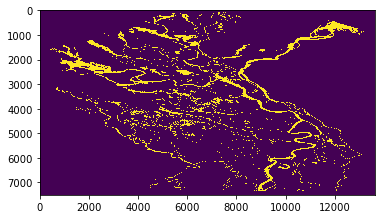

In [7]:
plt.imshow(water_mask)

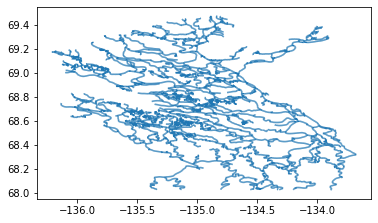

In [8]:
edges_grwl = gpd.read_file(grwl_data/'centerlines'/tile_name)
widths_df = gpd.read_file(tile_dir/'width_geometries.geojson').to_crs({'init':'epsg:4326'})
edges_orinoco = gpd.read_file(tile_dir/f'{tile_name}_edges.geojson').to_crs({'init':'epsg:4326'})
edges_orinoco.plot()

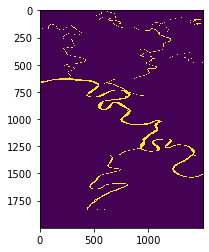

In [9]:
sy = np.s_[5_500:7_500]
sx = np.s_[7_000:8_500]
plt.imshow(water_mask[sy, sx])

In [10]:
slice_index = 0

In [11]:
# Mackenzie
figsize=(12, 10)

if (tile_name is 'NR08') & (slice_index == 0):
    sy = np.s_[2_000:3_000]
    sx = np.s_[4_000:5_000]
    loc='upper left'

elif (tile_name is 'NR08') & (slice_index == 1):
    sy = np.s_[5_600:6_600]
    sx = np.s_[7_750:8_750]
    loc='lower right'

plot_dir = Path(f'plot/{tile_name}_{slice_index}')
plot_dir.mkdir(exist_ok=True, parents=True)

In [12]:
profile_cropped = get_cropped_profile(profile, sx, sy)
extent = get_extent(profile_cropped['transform'], profile_cropped['width'], profile_cropped['height'])

In [13]:
profile_cropped = get_cropped_profile(profile, sx, sy)
extent = get_extent(profile_cropped['transform'], profile_cropped['width'], profile_cropped['height'])
extent

[-135.4908, -135.29080000000002, 69.0954, 68.8954]

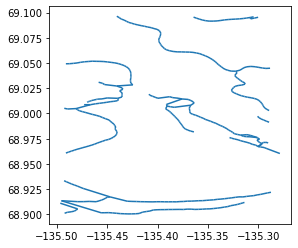

In [14]:
edges_grwl_c = edges_grwl.cx[extent[0]: extent[1], extent[2]: extent[3]]
edges_orinoco_c = edges_orinoco.cx[extent[0]: extent[1], extent[2]: extent[3]]
widths_df_c = widths_df.cx[extent[0]: extent[1], extent[2]: extent[3]]
edges_orinoco_c.plot()

In [15]:
ocean_layer = ocean_mask.astype(dtype=float)
ocean_layer[~ocean_mask.astype(bool)] = np.nan

In [16]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif', size=25)

In [17]:
M = 4
labels = ['Land', 'Inland Water', 'Ocean', 'Orinoco']

cNorm  = matplotlib.colors.Normalize(vmin=0, vmax=(M))
scalarMap = matplotlib.cm.ScalarMappable(norm=cNorm, cmap='viridis')

legend_elements = [Line2D([0], 
                          [0], 
                          marker='s',
                          color='w',
                          label=f'{labels[k]}',
                          markerfacecolor=scalarMap.to_rgba(k),
                          markeredgecolor='black',
                          markersize=10) for k in range(M-1)] +\
                    [Line2D([0], 
                          [0], 
                          marker=None,
                          color=scalarMap.to_rgba(M),
                          label=f'{labels[M-1]}',
                          linewidth=5,
                          #markerfacecolor=scalarMap.to_rgba(k),
                          #markeredgecolor='black',
                          #edgecolor='black',
                          markersize=10)]

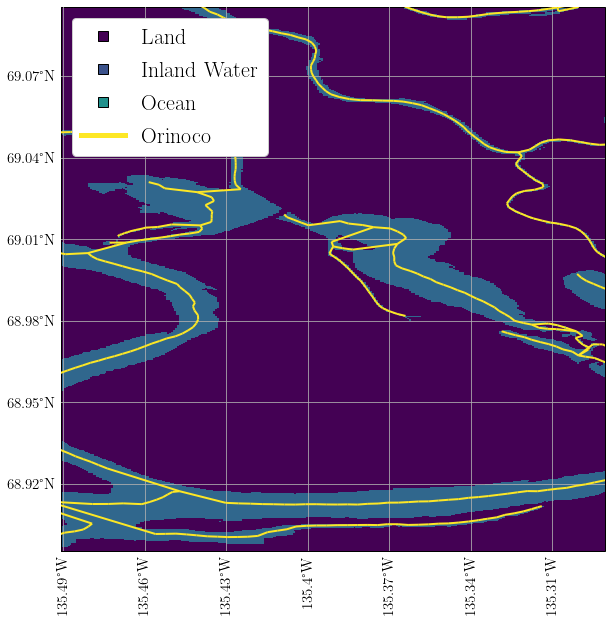

In [18]:
fig, ax = make_map(projection=ccrs.PlateCarree(),
                   figsize=figsize,
                   labels=True,
                   ticklabelsize=15
                   )
ax.set_extent([extent[k] for k in [0, 1, 2, 3]],  crs=ccrs.PlateCarree())

ax.add_geometries(edges_orinoco_c.geometry.values, 
                  crs=ccrs.PlateCarree(), 
                  edgecolor=scalarMap.to_rgba(4),
                  linewidth=2,
                  #linestyle='--',
                  facecolor=(0, 0, 0, 0),
                  zorder = 3,
                 )
#edges_orinoco_c.plot(color='yellow', ax=ax, alpha=1,zorder=2)



ax.imshow(water_mask[sy, sx], alpha=1, 
          zorder=1, 
          extent=extent,
          transform=ccrs.PlateCarree(),
          cmap='viridis', 
          vmax=(M-1))

ax.imshow(ocean_layer[sy, sx], 
          alpha=1, 
          zorder=2, 
          extent=extent,
          vmin=0, vmax=2,
          transform=ccrs.PlateCarree())
ax.legend(handles=legend_elements, loc=loc, fontsize=22, framealpha=1)
plt.savefig(plot_dir/'orinoco.png')

In [19]:
M = 4
labels = ['Land', 'Inland Water', 'Ocean', 'GRWL']

cNorm  = matplotlib.colors.Normalize(vmin=0, vmax=(M))
scalarMap = matplotlib.cm.ScalarMappable(norm=cNorm, cmap='viridis')

legend_elements = [Line2D([0], 
                          [0], 
                          marker='s',
                          color='w',
                          label=f'{labels[k]}',
                          markerfacecolor=scalarMap.to_rgba(k),
                          markeredgecolor='black',
                          markersize=10) for k in range(M-1)] +\
                    [Line2D([0], 
                          [0], 
                          marker=None,
                          color=scalarMap.to_rgba(M),
                          label=f'{labels[M-1]}',
                          linewidth=5,
                          #markerfacecolor=scalarMap.to_rgba(k),
                          #markeredgecolor='black',
                          #edgecolor='black',
                          markersize=10)]

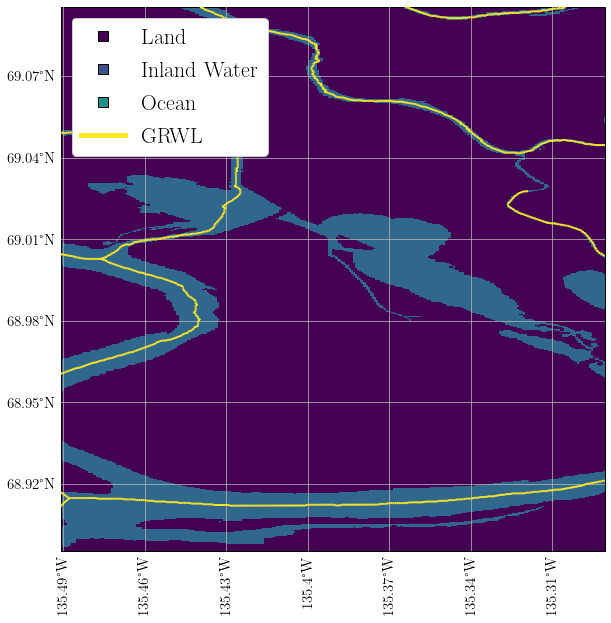

In [20]:
fig, ax = make_map(projection=ccrs.PlateCarree(),
                   figsize=figsize,
                   labels=True,
                   ticklabelsize=15,
                   )
ax.set_extent([extent[k] for k in [0, 1, 2, 3]],  crs=ccrs.PlateCarree())

#request = cimgt.Stamen('terrain-background') #GoogleTiles(style='satellite')##style='Toner')#(style='satellite')#OSM()#GoogleTiles(style='satellite')#OSM()#GoogleTiles(style='satellite')#OSM()#StamenTerrain()#GoogleTiles(style='satellite')
#ax.add_image(request, 10, alpha=1, zorder=1)
ax.imshow(water_mask[sy, sx], alpha=1, 
          zorder=1, 
          extent=extent,
          transform=ccrs.PlateCarree(),
          cmap='viridis', 
          vmax=(M-1))

ax.add_geometries(edges_grwl_c.geometry, 
              crs=ccrs.PlateCarree(), 
              edgecolor=scalarMap.to_rgba(4),
              linewidth=2,
              #linestyle='--',
              facecolor=(0, 0, 0, 0),
              zorder = 3,
             )


ax.imshow(ocean_layer[sy, sx], 
          alpha=1, 
          zorder=2, 
          extent=extent,
          vmin=0, vmax=2,
          transform=ccrs.PlateCarree())
ax.legend(handles=legend_elements, loc=loc, fontsize=22, framealpha=1)
plt.savefig(plot_dir/'grwl.png')

In [21]:
M = 1

cNorm  = matplotlib.colors.Normalize(vmin=0, vmax=(M))
scalarMap = matplotlib.cm.ScalarMappable(norm=cNorm, cmap='viridis')

legend_elements = [Line2D([0], 
                          [0], 
                          marker='s',
                          color='w',
                          label=f'No data',
                          markerfacecolor=scalarMap.to_rgba(1),
                          markeredgecolor='black',
                          markersize=10) ] +\
                    [Line2D([0], 
                          [0], 
                          marker=None,
                          color='green',
                          label=f'Width',
                          linewidth=2,
                          markersize=10)]

In [22]:
import scipy.ndimage as nd
mask_crop = water_mask[sy, sx]
outline = nd.morphology.binary_dilation(mask_crop, iterations = 3).astype(float)
outline[mask_crop.astype(bool)] = 0.
outline[outline == 0] = np.nan

nodata_diff = (water_mask & np.isnan(width_differences)).astype(float)
nodata_diff[nodata_diff == 0] = np.nan

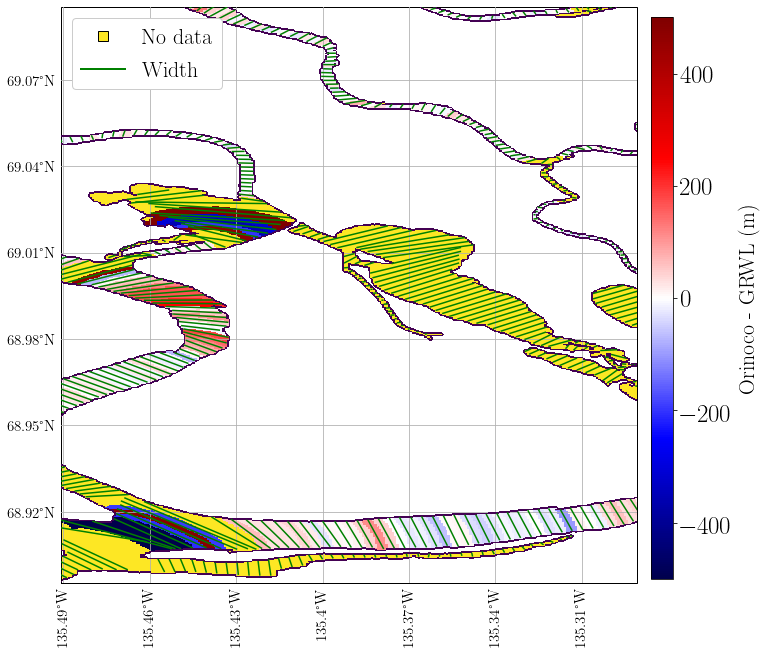

In [23]:
fig, ax = make_map(projection=ccrs.PlateCarree(),
                   figsize=figsize,
                   labels=True,
                   ticklabelsize=15,
                   )
ax.set_extent([extent[k] for k in [0, 1, 2, 3]],  crs=ccrs.PlateCarree())

#request = cimgt.Stamen('terrain-background') #GoogleTiles(style='satellite')##style='Toner')#(style='satellite')#OSM()#GoogleTiles(style='satellite')#OSM()#GoogleTiles(style='satellite')#OSM()#StamenTerrain()#GoogleTiles(style='satellite')
#ax.add_image(request, 10, alpha=1, zorder=1)

im = ax.imshow(width_differences[sy, sx], alpha=1, 
          zorder=1, 
          extent=extent,
          transform=ccrs.PlateCarree(),
          cmap='seismic',
          vmin = -500,
          vmax=500)

ax.imshow(nodata_diff[sy, sx], alpha=1, 
          zorder=2, 
          extent=extent,
          transform=ccrs.PlateCarree(),
          vmin=0, vmax=1)
ax.imshow(outline, alpha=1, 
          zorder=3, 
          extent=extent,
          transform=ccrs.PlateCarree())
divider = make_axes_locatable(ax)
if slice_index == 1:
    cax = fig.add_axes([.85, 0.13, 0.025, 0.78])
elif slice_index == 0:
    cax = fig.add_axes([.85, 0.13, 0.025, 0.78])

    
widths_df_c.plot(color='green', ax=ax, alpha=1,zorder=4)

fig.subplots_adjust(hspace=0, wspace=0, top=0.925, left=0.1)

fig.colorbar(im, cax=cax)
cax.set_ylabel('Orinoco - GRWL (m)', fontsize=22)

ax.legend(handles=legend_elements, loc=loc, fontsize=22, framealpha=1)
plt.savefig(plot_dir/'width_differences.png')

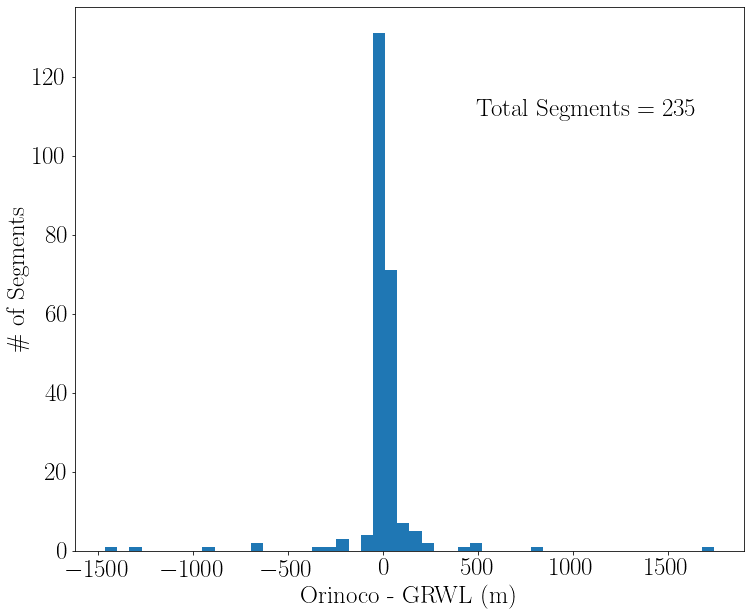

In [24]:
fig, ax = plt.subplots(figsize=figsize)
X = width_differences[sy, sx]
labels = segments[sy, sx]
data = get_features_from_array(labels, X)
data = data[~np.isnan(data)]
ax.hist(data, bins=50)
ax.set_xlabel('Orinoco - GRWL (m)')
ax.set_ylabel('\# of Segments')
ax.text(.6, .8, f'Total Segments = {len(data):,}', transform=ax.transAxes)
plt.savefig(plot_dir/'diff_histogram.png')